In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="4"

In [2]:
# importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, tqdm, re, time, itertools, sys
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense, Dropout
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# loading all data files into memory
start = time.time()

data_train = pd.read_csv('/data1/hom1/ict06/ECG Classification/mitbih_train.csv', header=None)
data_test = pd.read_csv('/data1/hom1/ict06/ECG Classification/mitbih_test.csv', header=None)
abnormal = pd.read_csv('/data1/hom1/ict06/ECG Classification/ptbdb_abnormal.csv', header=None)
normal = pd.read_csv('/data1/hom1/ict06/ECG Classification/ptbdb_normal.csv', header=None)

end = time.time()
print('Time taken: %.3f seconds' % (end-start))

print('Data loaded........')

Time taken: 3.223 seconds
Data loaded........


In [5]:
normal = normal.drop([187], axis=1)
abnormal = abnormal.drop([187], axis=1)

In [6]:
data_train.isnull().sum().to_numpy()


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [7]:
# checking the dataset shape
abnormal.shape, normal.shape

((10506, 187), (4046, 187))

In [8]:
# view first 4 rows of data
data_train.head(4)

0         1         2         3         4         5         6    \
0  0.977941  0.926471  0.681373  0.245098  0.154412  0.191176  0.151961   
1  0.960114  0.863248  0.461538  0.196581  0.094017  0.125356  0.099715   
2  1.000000  0.659459  0.186486  0.070270  0.070270  0.059459  0.056757   
3  0.925414  0.665746  0.541436  0.276243  0.196133  0.077348  0.071823   

        7         8         9    ...  178  179  180  181  182  183  184  185  \
0  0.085784  0.058824  0.049020  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.088319  0.074074  0.082621  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.043243  0.054054  0.045946  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.060773  0.066298  0.058011  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   186  187  
0  0.0  0.0  
1  0.0  0.0  
2  0.0  0.0  
3  0.0  0.0  

[4 rows x 188 columns]

In [9]:
# checking the columns
data_train.columns

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            178, 179, 180, 181, 182, 183, 184, 185, 186, 187],
           dtype='int64', length=188)

In [10]:
flatten_y = abnormal.values
flatten_y = flatten_y[:, 5:70].flatten()
flatten_y

array([0.93397045, 0.80104256, 0.7497828 , ..., 0.06976745, 0.06078224,
       0.06606765])

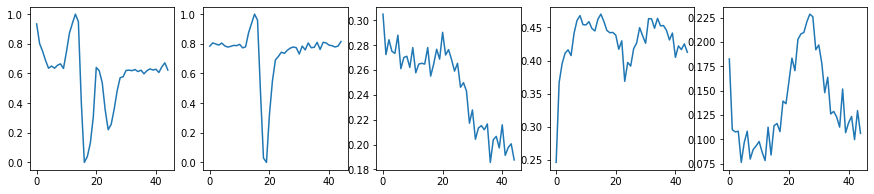

In [11]:
#Abnormal ECG visualization
plt.figure(figsize=(15, 3))
plt.title('ECG Visualization of Abormal Persons')
plt.subplot(1, 5, 1)
plt.plot(abnormal.values[0][5:50])
plt.subplot(1, 5, 2)
plt.plot(abnormal.values[10][5:50])
plt.subplot(1, 5, 3)
plt.plot(abnormal.values[20][5:50])
plt.subplot(1, 5, 4)
plt.plot(abnormal.values[40][5:50])
plt.subplot(1, 5, 5)
plt.plot(abnormal.values[44][5:50])

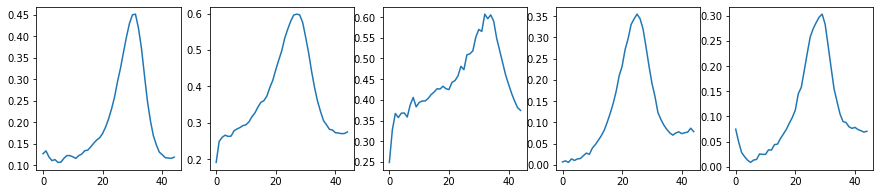

In [12]:
#Normal ECG visualization
plt.figure(figsize=(15, 3))
plt.title('ECG Visualization of Normal Persons')
plt.subplot(1, 5, 1)
plt.plot(normal.values[0][5:50])
plt.subplot(1, 5, 2)
plt.plot(normal.values[10][5:50])
plt.subplot(1, 5, 3)
plt.plot(normal.values[20][5:50])
plt.subplot(1, 5, 4)
plt.plot(normal.values[40][5:50])
plt.subplot(1, 5, 5)
plt.plot(normal.values[77][5:50])

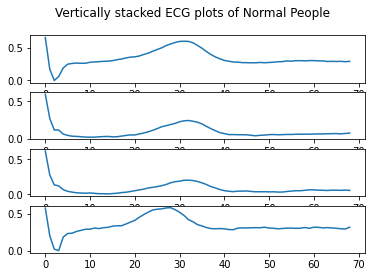

In [13]:
fig, axs = plt.subplots(4)
fig.suptitle('Vertically stacked ECG plots of Normal People')
axs[0].plot(normal.values[10][1:70])
axs[1].plot(normal.values[55][1:70])
axs[2].plot(normal.values[87][1:70])
axs[3].plot(normal.values[98][1:70])

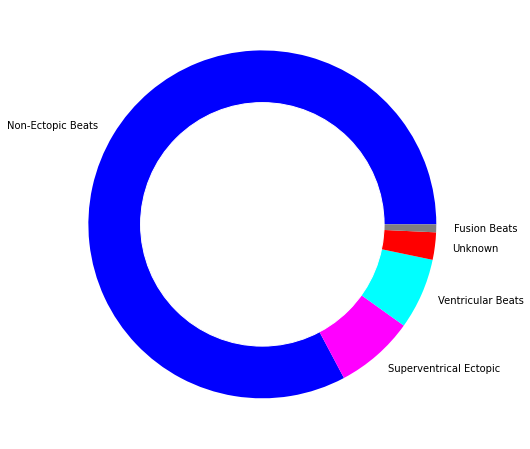

In [14]:
# viewing the distribution of beats in our dataset 
plt.figure(figsize=(10, 8))
circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(data_train[187].value_counts(), labels=['Non-Ectopic Beats', 'Superventrical Ectopic', 'Ventricular Beats',
                                                'Unknown', 'Fusion Beats'], colors=['blue', 'magenta', 'cyan', 
                                                                                   'red', 'grey'])
p = plt.gcf()
p.gca().add_artist(circle)

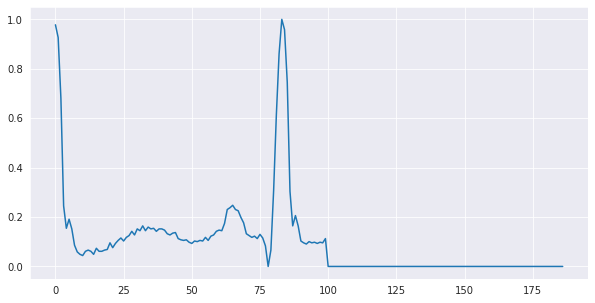

In [15]:
sns.set_style('darkgrid')
plt.figure(figsize=(10, 5))
plt.plot(data_train.iloc[0, 0:187])

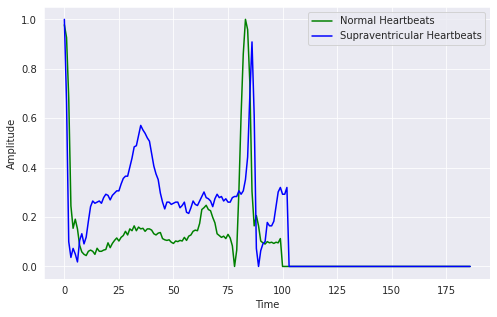

In [16]:
# Data Preprocessing
# making the class labels for our dataset
data_1 = data_train[data_train[187] == 1]
data_2 = data_train[data_train[187] == 2]
data_3 = data_train[data_train[187] == 3]
data_4 = data_train[data_train[187] == 4]

sns.set_style('darkgrid')
plt.figure(figsize=(8, 5))
plt.plot(data_train.iloc[0, 0:187], color='green', label='Normal Heartbeats')
plt.plot(data_1.iloc[0, 0:187], color='blue', label='Supraventricular Heartbeats')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()

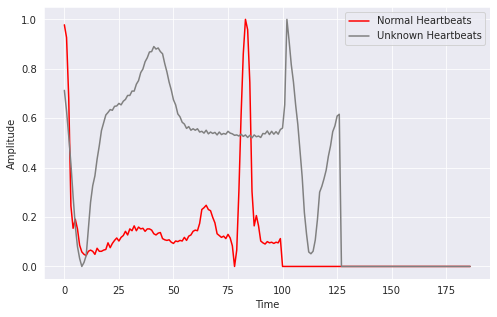

In [17]:
sns.set_style('darkgrid')
plt.figure(figsize=(8, 5))
plt.plot(data_train.iloc[0, 0:187], color='red', label='Normal Heartbeats')
plt.plot(data_4.iloc[0, 0:187], color='grey', label='Unknown Heartbeats')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()

In [18]:
y_abnormal = np.ones(abnormal.shape[0])
y_abnormal = pd.DataFrame(y_abnormal)

y_normal = np.zeros(normal.shape[0])
y_normal = pd.DataFrame(y_normal)

# merging the original dataframe
X = pd.concat([abnormal, normal], sort=True)
y = pd.concat([y_abnormal, y_normal], sort=True)

print(X.shape)
print(y.shape)

(14552, 187)
(14552, 1)


In [19]:
#Data Augmentation
from sklearn.utils import resample
data_1_resample = resample(data_1, n_samples=20000, 
                           random_state=123, replace=True)
data_2_resample = resample(data_2, n_samples=20000, 
                           random_state=123, replace=True)
data_3_resample = resample(data_3, n_samples=20000, 
                           random_state=123, replace=True)
data_4_resample = resample(data_4, n_samples=20000, 
                           random_state=123, replace=True)
data_0 = data_train[data_train[187] == 0].sample(n=20000, random_state=123)

In [20]:
train_dataset = pd.concat([data_0, data_1_resample, data_2_resample, data_3_resample, 
                          data_4_resample])

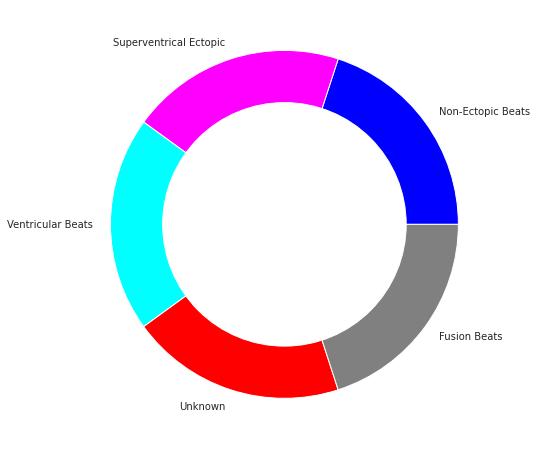

In [21]:
# viewing the distribution of beats in our dataset 
plt.figure(figsize=(10, 8))
circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(train_dataset[187].value_counts(), labels=['Non-Ectopic Beats', 'Superventrical Ectopic', 'Ventricular Beats',
                                                'Unknown', 'Fusion Beats'], colors=['blue', 'magenta', 'cyan', 
                                                                                   'red', 'grey'])
p = plt.gcf()
p.gca().add_artist(circle)

In [22]:
target_train = train_dataset[187]
target_test = data_test[187]
target_train.unique()

array([0., 1., 2., 3., 4.])

In [23]:
y_train = to_categorical(target_train)
y_test = to_categorical(target_test)
y_train[:4]

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [24]:
# making train & test splits
X_train = train_dataset.iloc[:, :-1].values
X_test = data_test.iloc[:, :-1].values

In [25]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(100000, 187)
(21892, 187)
(100000, 5)
(21892, 5)


In [26]:
X_train = X_train.reshape(len(X_train), X_train.shape[1], 1)
X_test = X_test.reshape(len(X_test), X_test.shape[1], 1)
X_train.shape, X_test.shape

((100000, 187, 1), (21892, 187, 1))

In [27]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
lrr= ReduceLROnPlateau(monitor='val_accuracy', factor=.001, patience=3, min_lr=1e-7)

In [28]:
from keras.layers import Dense, Dropout, LSTM, Embedding,Flatten
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
import tensorflow as tf
from keras.callbacks import EarlyStopping

lstm_model = Sequential()
lstm_model.add(LSTM(32, input_shape=(187, 1) , return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(Dropout(0.1))
lstm_model.add(Flatten())

lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dense(5, activation='softmax'))

lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

2022-10-15 16:45:14.925519: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-15 16:45:16.140066: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22349 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:81:00.0, compute capability: 8.6


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 187, 32)           4352      
                                                                 
 dropout (Dropout)           (None, 187, 32)           0         
                                                                 
 lstm_1 (LSTM)               (None, 187, 64)           24832     
                                                                 
 dropout_1 (Dropout)         (None, 187, 64)           0         
                                                                 
 flatten (Flatten)           (None, 11968)             0         
                                                                 
 dense (Dense)               (None, 64)                766016    
                                                                 
 dense_1 (Dense)             (None, 64)                4

In [30]:
logger = CSVLogger('logs.csv', append=True)
his = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, 
          validation_data=(X_test, y_test), callbacks=[lrr])

Epoch 1/50


2022-10-15 16:45:46.784741: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2022-10-15 16:45:47.713902: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3125/3125 [==============================] - 53s 16ms/step - loss: 0.3300 - accuracy: 0.8818 - val_loss: 0.2172 - val_accuracy: 0.9235 - lr: 0.0010
Epoch 2/50
3125/3125 [==============================] - 48s 15ms/step - loss: 0.1523 - accuracy: 0.9464 - val_loss: 0.2307 - val_accuracy: 0.9229 - lr: 0.0010
Epoch 3/50
3125/3125 [==============================] - 47s 15ms/step - loss: 0.1036 - accuracy: 0.9640 - val_loss: 0.1957 - val_accuracy: 0.9377 - lr: 0.0010
Epoch 4/50
3125/3125 [==============================] - 47s 15ms/step - loss: 0.0790 - accuracy: 0.9725 - val_loss: 0.1753 - val_accuracy: 0.9467 - lr: 0.0010
Epoch 5/50
3125/3125 [==============================] - 48s 15ms/step - loss: 0.0645 - accuracy: 0.9779 - val_loss: 0.1920 - val_accuracy: 0.9408 - lr: 0.0010
Epoch 6/50
3125/3125 [==============================] - 49s 16ms/step - loss: 0.0538 - accuracy: 0.9818 - val_loss: 0.2203 - val_accuracy: 0.9396 - lr: 0.0010
Epoch 7/50
3125/3125 [==============================] - 4

In [32]:
lstm_model.evaluate(X_test, y_test)


685/685 [==============================] - 5s 7ms/step - loss: 0.1439 - accuracy: 0.9711


[0.14393630623817444, 0.9710853099822998]

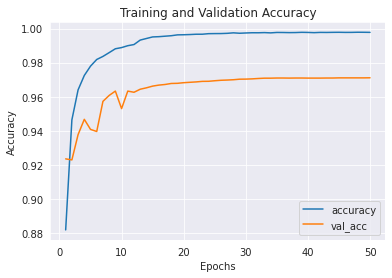

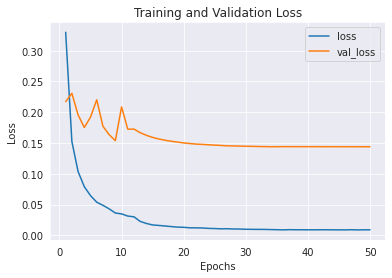

In [33]:
history = his.history
history.keys()

epochs = range(1, len(history['loss']) + 1)
acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

plt.figure()
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label='val_acc')
plt.legend()

plt.figure()
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, label='loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.legend()

In [34]:
y_pred = lstm_model.predict(X_test)
y_real = np.argmax(y_pred, axis = 1)
confusion_matrix(np.argmax(y_test, axis = 1), y_real)

685/685 [==============================] - 5s 6ms/step


array([[17690,   212,   108,    74,    34],
       [   73,   468,     9,     5,     1],
       [   28,    14,  1378,    25,     3],
       [   11,     0,    14,   136,     1],
       [   13,     1,     7,     0,  1587]])

<AxesSubplot:>

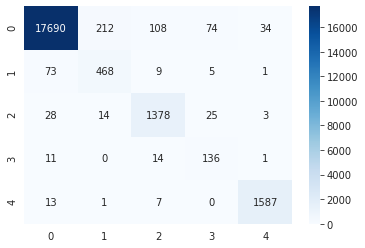

In [35]:
plt.figure()
sns.heatmap(confusion_matrix(np.argmax(y_test, axis = 1), y_real), annot=True, fmt='0.0f', cmap='Blues')

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
metrics = pd.DataFrame(lstm_model.history.history)
metrics

Empty DataFrame
Columns: []
Index: []

In [38]:
ECGlstm_model_history_df = pd.DataFrame(his.history) 
with open('ECGlstm_model_history_df.csv', mode='w') as f:
   ECGlstm_model_history_df.to_csv(f)

In [40]:
lstm_model.save('/data1/hom1/ict06/Models/ECG_LSTM50epochs.h5')

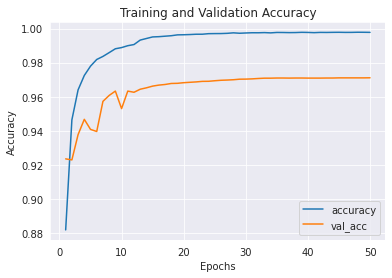

In [41]:
plt.figure()
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label='val_acc')
plt.legend()
plt.savefig('ECG_LSTM50epochsaccuracy.png', dpi=300, bbox_inches='tight')

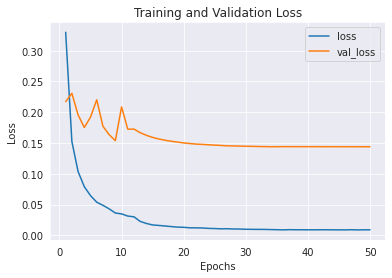

In [42]:
plt.figure()
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, label='loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.legend()
plt.savefig('ECG_LSTM50epochsloss.png', dpi=300, bbox_inches='tight')

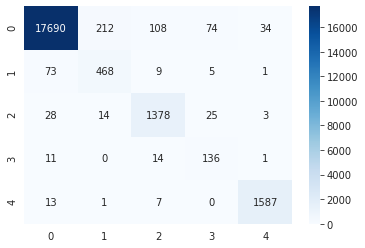

In [43]:
plt.figure()
sns.heatmap(confusion_matrix(np.argmax(y_test, axis = 1), y_real), annot=True, fmt='0.0f', cmap='Blues')
plt.savefig('ConfusionMatrixECG_LSTM50epochs.png', dpi=300, bbox_inches='tight')